<a href="https://colab.research.google.com/github/olgaminguett/CE6003/blob/master/Etivity_assignment3_OlgaMinguett_20179766.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Etivity Assignment 3: Object co-localisation
In this assignment we will use the [Deep Descriptor Transforming (DDT) Technique](https://arxiv.org/pdf/1707.06397.pdf) to perform object co-localisation. The object localisation task involves finding the location of the primary object in an image (same object as image classification result). In the object co-localisation task the goal is to find the objects in images all of the same class. As detailed in the DDT paper, this can be achieved in a unsuperivsed manner from the feature map outputs of a pre-trained network. (In the image: Green bounding box is ground truth, Red boxes are obtained from DDT)
![link text](https://github.com/tonyscan6003/CE6003/blob/master/images/etivity3_assignment_img.JPG?raw=true)

This technique (like Class activiation mapping) demonstrates that spatial information is contained with Deep Neural Networks trained for classification. This information can be used to generate region proposals or for direct object detection. The  unsupervised technique proposed in this paper is useful as it avoids the necessity of having bounding box information to adapt the pre-trained network for localisation.

In this Assignment you will perform object co-localisation using the stanford dogs dataset and the pre-trained VGG-16 network. This Jupyter notebook loads the stanford dogs dataset and also sets up the pre-trained Keras VGG-16 model so that the features of the convolutional layer are output. (Output layers of the model can be changed if required).  

In section 4. of the notebook you will implement the DDT algorithm and demonstrate prediction of bounding boxes. (Ground truth bounding boxes are available for comparison with your prediction).

You may find the following information useful:

*   [Sklearn PCA Functions](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
* [Tensorflow resize](https://www.tensorflow.org/api_docs/python/tf/image/resize) (interpolation function)
*   OpenCV Connected Components (PyImageSearch example [link text](https://www.pyimagesearch.com/2021/02/22/opencv-connected-component-labeling-and-analysis/)) Note that if you want to use OpenCv on the output tensors then it will be necessary to need to convert the tensor to a numpy array uisng `.numpy()` and also ensure that have the numpy array in uint8 format `.astype(np.uint8)`
* If you wish to display any of the images from the dataset, please note that they have been processed prior to input to the network. In order to unprocess the image for display, please use: `helper.unprocess_image(img)`

In order to obtain an exemplary grade you will be required to implement the DDT+ algorithm. This will involve use of additional feature map information to refine the position of the bounding box compared to the basic approach (as shown in the images below). You will implement the DDT+ algorithm on the [Pascale Visual Object Classes Challenge](https://homepages.inf.ed.ac.uk/ckiw/postscript/ijcv_voc09.pdf) "Sheep" class. This is more challenging than the stanford dogs dataset, as objects appear at different scales. Note that the DDT+ approach also causes failures in bounding boxes for many images, you can comment on this in your notebook. 

Image: DDT+ Performance (Cyan: DDT+ bouding boxes, Red DDT: bounding boxes, Green: Ground Truth) 
![link text](https://github.com/tonyscan6003/CE6003/blob/master/images/etivity3b_assignment.JPG?raw=true)

* Note: Completed list of VoC Classes 0-airplane, 1-bicycle, 2-bird, 3-boat, 4-bottle, 5-bus, 6-car, 7-cat, 8-chair, 9-cow, 10-dining table, 11-dog, 12-horse, 13-motorbike, 14-person, 15-potted plant, 16-sheep, 17-sofa, 18-train, 19-TV/monitor.










# 1. HouseKeeping
 Clone Repository & Import Packages 

In [1]:
# Clone repository to gain access to helper.py
!git clone https://github.com/tonyscan6003/CE6003.git

Cloning into 'CE6003'...
remote: Enumerating objects: 383, done.
remote: Counting objects: 100% (241/241), done.
remote: Compressing objects: 100% (215/215), done.
remote: Total 383 (delta 108), reused 0 (delta 0), pack-reused 142
Receiving objects: 100% (383/383), 5.98 MiB | 34.62 MiB/s, done.
Resolving deltas: 100% (167/167), done.


In [2]:
import tensorflow as tf
import CE6003.python.helper as helper
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow_datasets as tfds

In [3]:
# Global Variables
HW_trg = helper.myList[0]      # Target Input Image size
batch_size = helper.myList[1]  # Batch Size
data_set = ["stanford_dogs"]   # Dataset (and add class integer to list for VoC))
#data_set = ["voc",16]    # VoC Dataset with Sheep Class

## 2A. Import Dataset

In [4]:
if data_set[0] == "voc":   
   src_train_dataset,info = tfds.load(data_set[0],split='train',with_info=True)
   src_val_dataset,info = tfds.load(data_set[0],split='validation',with_info=True)
   src_test_dataset,info = tfds.load(data_set[0],split='test',with_info=True)
elif data_set[0] == "stanford_dogs":
   src_train_dataset,info = tfds.load(data_set[0],split='train',with_info=True)
   src_test_dataset,info = tfds.load(data_set[0],split='test',with_info=True)
print(info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteR0W6NZ/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteR0W6NZ/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='stanford_dogs',
    version=0.2.0,
    description='The Stanford Dogs dataset contains images of 120 breeds of dogs from around
the world. This dataset has been built using images and annotation from
ImageNet for the task of fine-grained image categorization. There are
20,580 images, out of which 12,000 are used for training and 8580 for
testing. Class labels and bounding box annotations are provided
for all the 12,000 images.',
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        }

## 2B. Create Train and Test dataset splits 

Note that the images from the stanford dog and many other datasets are not uniform in size. The `gen_datasets` function calls other routines from helper.py that scale the images from the dataset so the longest side fits into the 224 x 224 input window size of VGG16. The aspect ratio of the image is preserved, so the shorter side of the image is padded with zeros. The shorter side is randomly translated providing some data augmentation. (Augmentation is not important for this task). The routines also scale ground truth bounding boxes to match the scale and translation of the image.

In [5]:
train_dataset, test_dataset =helper.gen_datasets(data_set,src_train_dataset,src_test_dataset)

Display Some Training Images with Ground truth Bounding Box

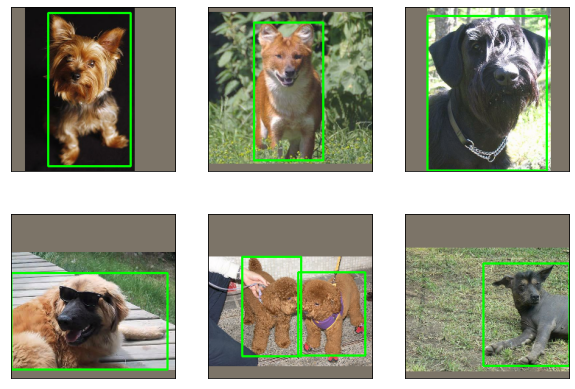

In [6]:
helper.display_dataset_img(train_dataset)

## 3A. Import and Setup VGG model
For this assignment we will use the convolutional layers of the VGG-16 module. The sturucture & layer names of the VGG-16 can be viewed on [Netscope](https://ethereon.github.io/netscope/#/preset/vgg-16). The layer_names variable allows selection of the output layer(s) of the model.


In [7]:
# Select Output Layers
layer_names = ['block5_conv3']

# Load base model
def base_vgg_model():
   IMG_SHAPE = (HW_trg, HW_trg, 3)
   base_vgg_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                             include_top=False,
                                             weights='imagenet')
   
   op_list=[base_vgg_model.get_layer(layer).output for layer in layer_names]
   base_model= tf.keras.Model(inputs=base_vgg_model.input, outputs=op_list)

   return base_model

In [8]:
base_model = base_vgg_model()
base_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

## 3B. Extract output features maps from Model.

The function `gen_batch_features` in the code cell below applies `n_img` images from the test or training set to the model. The function returns batch tensors of the image, ground truth boxes and features. The 0 dimension of the tensor corresponds to each image/feature pair.

In [9]:
def gen_batch_features(train_dataset,n_img):

    cntr = 0
    for img, boxes, obj_cen, labels in train_dataset.take(n_img):
       img = img.to_tensor(shape=[batch_size, HW_trg, HW_trg, 3])
       A = base_model(img)

       # Append output features 
       if cntr >0:
          op_features = tf.concat([op_features,A],axis=0)
          img_batch = tf.concat([img_batch,img],axis=0)
          boxes_batch = tf.concat([boxes_batch,boxes],axis=0)
       else:   
          op_features= A
          img_batch = img
          boxes_batch = boxes
       cntr +=1  
     
    return img_batch,boxes_batch,op_features   

In [10]:
n_img=100 # Default value.
img_batch,batch_boxes,op_features=gen_batch_features(train_dataset,n_img)
img_batch_test,batch_boxes_test,op_features_test=gen_batch_features(test_dataset,n_img)
print(np.shape(op_features))
print(np.shape(batch_boxes_test))
print(np.shape(img_batch_test))

(100, 14, 14, 512)
(100, None, 4)
(100, 224, 224, 3)


## 4. DDT Algorithm

In the code cells below add your implementation of the DDT Algorithm for object co-localisation.


# 5. Display results

You can display your results using the code cell below. You can display an image(s) similar to that shown at the start of the notebook, containing the image, ground truth bounding box and the bounding box produced by the DDT method. You can also show the binary map produced by indicator P (positive values).

The function `helper.image_with_gt_boxes(img,boxes,colour)` can be used to plot a bounding box on an image where the bounding box is in the form [ymin,xmin,ymax,xmax] and values are normalised between zero and 1. 

In [ ]:
fig = plt.figure(figsize=(15, 5))
n=8

# Iterate through some images
for k in range(n):
   curr_img = np.asarray(helper.unprocess_image(img_batch_test[k, :, :,:]))
   # draw a green rectangle to visualize the bounding rect
   curr_img=helper.image_with_gt_boxes(curr_img,batch_boxes_test[k],(0,255,0))

   # Plot image and show related indicator
   ax = fig.add_subplot(1, n, k + 1, xticks=[], yticks=[])
   ax.imshow(curr_img)
   ax.set_title('Input Image')